C:\Users\Lutz_Laptop\AppData\Local\Temp\ipykernel_17012\2107627084.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D_it = np.trapz(Dit_vs_E, E_grid)  # units: 1/cm^2
C:\Users\Lutz_Laptop\AppData\Local\Temp\ipykernel_17012\2107627084.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  q_it = q * np.trapz(Dit_vs_E * (occup - occup_CNL), E_grid)
C:\Users\Lutz_Laptop\AppData\Local\Temp\ipykernel_17012\2107627084.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D_it_eff = np.trapz(Dit_vs_E, E_grid)


,Metal,Phi_n_S_CNL,Phi_p_S_CNL,S_simple,D_it_total_cm2,C_s_F_per_cm2
0,Ni2Si,1.30,1.93,1.0,3.230000e+13,3.766427e-08
1,Ni,1.45,1.78,1.0,3.230000e+13,3.766427e-08
2,Ti,0.63,2.60,1.0,3.230000e+13,3.766427e-08
3,Al,0.36,2.87,1.0,3.230000e+13,3.766427e-08
4,TiNi,1.10,2.13,1.0,3.230000e+13,3.766427e-08
5,TiAl,1.00,2.23,1.0,3.230000e+13,3.766427e-08
6,TiC,1.00,2.23,1.0,3.230000e+13,3.766427e-08
7,Ti3SiC2,1.20,2.03,1.0,3.230000e+13,3.766427e-08
8,NiGe,1.30,1.93,1.0,3.230000e+13,3.766427e-08


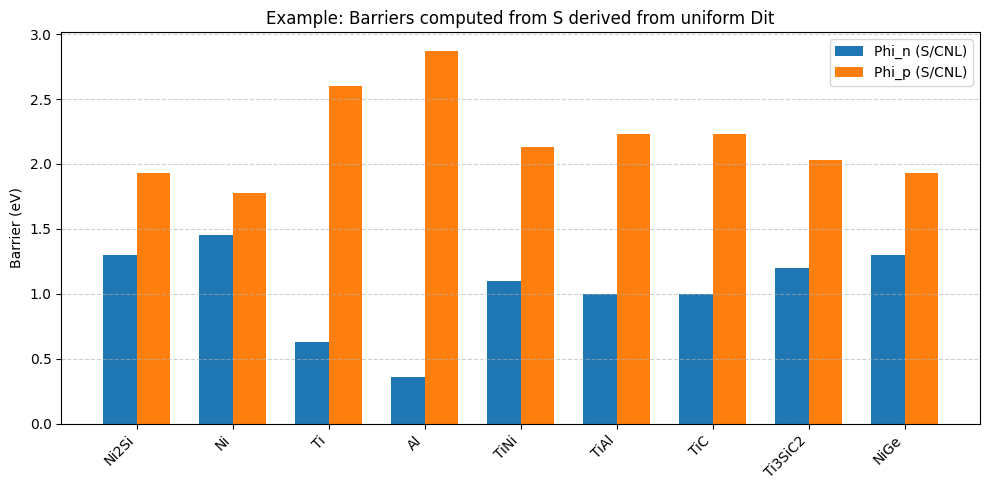

Self-consistent solver example for Ni (approx):
psi_s = 1.3851 eV, Q_it = 6.269e-08 C/cm^2, Q_s = -6.269e-08 C/cm^2, S_est ~ 1.000


In [ ]:
# Re-run the Dit-based Schottky barrier helper (retry after previous reset).
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
kB = 8.617333262145e-5  # eV/K
q = 1.602176634e-19  # C
eps0 = 8.8541878128e-14  # F/cm (vacuum permittivity)
# Material constants for SiC (user can change)
eps_r_SiC = 10.0  # relative permittivity (approx)
eps_s = eps0 * eps_r_SiC  # F/cm
Nc = 1.6e19  # effective density of states conduction (cm^-3) -- rough
Nv = 1.6e19  # valence DOS (cm^-3) -- rough
T = 300.0
beta = 1.0/(kB*T)

def compute_S_from_Dit(Dit_vs_E, E_grid, Nd, approx_Vbi=None):
    D_it = np.trapz(Dit_vs_E, E_grid)  # units: 1/cm^2
    if approx_Vbi is None:
        Vbi = 0.5  # eV, crude default
    else:
        Vbi = approx_Vbi
    C_s = np.sqrt(eps_s * q * Nd / (2.0 * Vbi))  # F/cm^2
    S = 1.0 / (1.0 + (q**2 * D_it) / C_s)
    return S, D_it, C_s

def phi_from_S_CNL(phi_m, chi, Eg, S, CNL):
    Phi_n = S * (phi_m - chi) + (1.0 - S) * (Eg - CNL)
    Phi_p = S * (Eg + chi - phi_m) + (1.0 - S) * CNL
    return Phi_n, Phi_p

# Slightly simplified self-consistent solver (keeps assumptions explicit)
def solve_selfconsistent_Dit(Dit_vs_E, E_grid, CNL, Nd, semiconductor_params, phi_m, chi, Eg, is_n_type=True):
    eps_r = semiconductor_params.get("eps_r", eps_r_SiC)
    eps_s_local = eps0 * eps_r
    Tloc = semiconductor_params.get("T", T)
    beta_loc = 1.0/(kB*Tloc)
    Nd = float(Nd)
    if is_n_type:
        E_F_bulk_rel_VBM = Eg - kB*Tloc * np.log(semiconductor_params.get("Nc", Nc) / Nd)
    else:
        E_F_bulk_rel_VBM = kB*Tloc * np.log(semiconductor_params.get("Nv", Nv) / Nd)
    def f(E, Efs):
        return 1.0 / (1.0 + np.exp(beta_loc*(E - Efs)))
    def Q_it_for_psi(psi_s):
        E_fs = E_F_bulk_rel_VBM - psi_s
        occup = f(E_grid, E_fs)
        occup_CNL = 0.5
        q_it = q * np.trapz(Dit_vs_E * (occup - occup_CNL), E_grid)
        return q_it
    def Q_s_for_psi(psi_s):
        if psi_s <= 0:
            return 0.0
        Qs = - np.sqrt(2.0 * eps_s_local * q * Nd * psi_s)
        return Qs
    from scipy.optimize import brentq
    lb = 1e-6
    ub = Eg - 1e-6
    def F(psi):
        return Q_it_for_psi(psi) + Q_s_for_psi(psi)
    try:
        psi_sol = brentq(F, lb, ub, maxiter=200, xtol=1e-6)
    except Exception as e:
        return None, None, None, None
    Qit = Q_it_for_psi(psi_sol)
    Qs = Q_s_for_psi(psi_sol)
    D_it_eff = np.trapz(Dit_vs_E, E_grid)
    C_s_at = np.sqrt(eps_s_local * q * Nd / (2.0 * max(psi_sol,1e-9)))
    S_est = 1.0 / (1.0 + (q**2 * D_it_eff) / C_s_at)
    return psi_sol, Qit, Qs, S_est

# Example usage
metals = ["Ni2Si", "Ni", "Ti", "Al", "TiNi", "TiAl", "TiC", "Ti3SiC2", "NiGe"]
phi_m_dict = {"Ni2Si": 4.8, "Ni": 5.05, "Ti": 4.33, "Al": 4.08, "TiNi": 4.15, "TiAl": 4.8, "TiC": 4.25, "Ti3SiC2": 4.6, "NiGe": 4.8}
chi = 3.2
Eg = 3.23
CNL = 1.51
E_grid = np.linspace(0, Eg, 501)
Dit_uniform = np.ones_like(E_grid) * 1e13
Nd = 4.33e17
S_simple, D_it_total, C_s_est = compute_S_from_Dit(Dit_uniform, E_grid, Nd, approx_Vbi=0.5)
phi_results = {}
for m in metals:
    phi_m = phi_m_dict[m]
    Phi_n, Phi_p = phi_from_S_CNL(phi_m, chi, Eg, S_simple, CNL)
    phi_results[m] = {"Phi_n_S_CNL": Phi_n, "Phi_p_S_CNL": Phi_p}
sem_params = {"eps_r": eps_r_SiC, "Nc": Nc, "Nv": Nv, "T": T}
psi_sol, Qit, Qs, S_est = solve_selfconsistent_Dit(Dit_uniform, E_grid, CNL, Nd, sem_params, phi_m_dict["Ni"], chi, Eg, is_n_type=True)
results_df = pd.DataFrame.from_dict(phi_results, orient="index")
results_df["S_simple"] = S_simple
results_df["D_it_total_cm2"] = D_it_total
results_df["C_s_F_per_cm2"] = C_s_est

# Display results and plot
from IPython.display import display, HTML
display( results_df.reset_index().rename(columns={"index":"Metal"}))

plt.figure(figsize=(10,5))
dfplot = results_df.reset_index().rename(columns={"index":"Metal"})
x = np.arange(len(dfplot))
width = 0.35
plt.bar(x - width/2, dfplot["Phi_n_S_CNL"], width, label="Phi_n (S/CNL)")
plt.bar(x + width/2, dfplot["Phi_p_S_CNL"], width, label="Phi_p (S/CNL)")
plt.xticks(x, dfplot["Metal"], rotation=45, ha="right")
plt.ylabel("Barrier (eV)")
plt.title("Example: Barriers computed from S derived from uniform Dit")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print("Self-consistent solver example for Ni (approx):")
print(f"psi_s = {psi_sol:.4f} eV, Q_it = {Qit:.3e} C/cm^2, Q_s = {Qs:.3e} C/cm^2, S_est ~ {S_est:.3f}")


Converts a given Dit(E) into an effective pinning factor 𝑆 using the common small-signal formula \
$S \approx \frac{1}{1+q^2 D_{i t} / C_s}$\
where $D_{i t}=\int \operatorname{Dit}(E) dE$ (states/cm²) and $C_S$ is the semiconductor depletion capacitance (F/cm²).

The solver assumes interface states are neutral at the CNL (i.e., occupancy = 0.5 at CNL). That’s a standard choice but can be changed if you have a different neutrality definition